In [7]:
!apt-get update -qq
!apt-get install -y swig
!pip install Box2D-kengz
!pip install gymnasium[box2d] --quiet


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 140 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (794 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 127400 files and directories currently installed

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

env = gym.make('BipedalWalker-v3')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_high = env.action_space.high[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action = max_action
    def forward(self, state):
        a = torch.relu(self.l1(state))
        a = torch.relu(self.l2(a))
        a = torch.tanh(self.l3(a))
        return a * self.max_action


In [15]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)
    def forward(self, state, action):
        q = torch.relu(self.l1(torch.cat([state, action], 1)))
        q = torch.relu(self.l2(q))
        q = self.l3(q)
        return q


In [16]:
class ReplayBuffer:
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = int(max_size)
        self.ptr = 0
    def add(self, data):
        if len(self.storage) == self.max_size:
            self.storage[self.ptr] = data
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(data)
    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = [], [], [], [], []
        for i in ind:
            state, action, reward, next_state, done = self.storage[i]
            batch_states.append(np.array(state, copy=False))
            batch_actions.append(np.array(action, copy=False))
            batch_rewards.append(np.array(reward, copy=False))
            batch_next_states.append(np.array(next_state, copy=False))
            batch_dones.append(np.array(done, copy=False))
        return (torch.FloatTensor(np.array(batch_states)).to(device),
                torch.FloatTensor(np.array(batch_actions)).to(device),
                torch.FloatTensor(np.array(batch_rewards)).unsqueeze(1).to(device),
                torch.FloatTensor(np.array(batch_next_states)).to(device),
                torch.FloatTensor(np.array(batch_dones)).unsqueeze(1).to(device))


In [17]:
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        self.replay_buffer = ReplayBuffer()
        self.max_action = max_action
        self.discount = 0.99
        self.tau = 0.005
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()
    def train(self, batch_size=100):
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        target_Q = self.critic_target(next_state, self.actor_target(next_state))
        target_Q = reward + ((1 - done) * self.discount * target_Q).detach()
        current_Q = self.critic(state, action)
        critic_loss = nn.MSELoss()(current_Q, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        actor_loss = -self.critic(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


In [18]:
agent = DDPGAgent(state_dim, action_dim, action_high)
max_episodes = 300
max_timesteps = 1500
batch_size = 100
episode_rewards = []

for episode in range(max_episodes):
    state, _ = env.reset()
    episode_reward = 0
    for t in range(max_timesteps):
        action = agent.select_action(np.array(state))
        action = (action + np.random.normal(0, 0.1, size=action_dim)).clip(-action_high, action_high)
        next_state, reward, done, truncated, _ = env.step(action)
        done_bool = float(done or truncated)
        agent.replay_buffer.add((state, action, reward, next_state, done_bool))
        state = next_state
        episode_reward += reward
        if done or truncated:
            break
        if len(agent.replay_buffer.storage) > batch_size:
            agent.train(batch_size)
    episode_rewards.append(episode_reward)
    print("Episode:", episode, "Reward:", episode_reward)


Episode: 0 Reward: -91.95098429446443
Episode: 1 Reward: -119.86750568365966
Episode: 2 Reward: -127.79252548653352
Episode: 3 Reward: -127.36666266325727
Episode: 4 Reward: -126.51035178636899
Episode: 5 Reward: -196.4722878234224
Episode: 6 Reward: -101.06093906301815
Episode: 7 Reward: -100.88814418784311
Episode: 8 Reward: -100.97117428476315
Episode: 9 Reward: -100.28146548851825
Episode: 10 Reward: -105.98312112235072
Episode: 11 Reward: -198.91475080002346
Episode: 12 Reward: -99.18286312867976
Episode: 13 Reward: -103.36927418498962
Episode: 14 Reward: -99.07021019083297
Episode: 15 Reward: -97.57654019895321
Episode: 16 Reward: -98.31852371844471
Episode: 17 Reward: -99.68360838239012
Episode: 18 Reward: -100.42177598921143
Episode: 19 Reward: -105.30667148103853
Episode: 20 Reward: -100.42548768455765
Episode: 21 Reward: -99.51868796634457
Episode: 22 Reward: -104.51907969521764
Episode: 23 Reward: -101.5107248122737
Episode: 24 Reward: -101.40614456929542
Episode: 25 Reward:

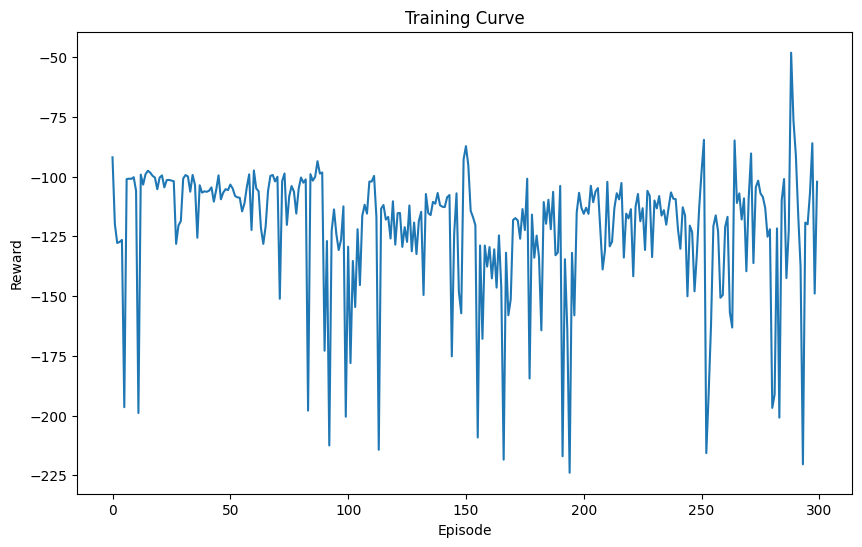

In [19]:
plt.figure(figsize=(10,6))
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Curve")
plt.show()


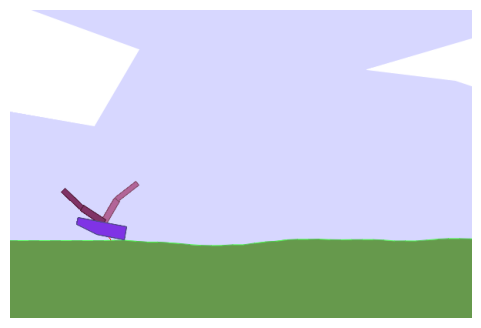

In [25]:
import time
from IPython.display import clear_output, display

env_vis = gym.make('BipedalWalker-v3', render_mode="rgb_array")
state, _ = env_vis.reset()
for t in range(1500):
    frame = env_vis.render()
    plt.figure(figsize=(6,4))
    plt.imshow(frame)
    plt.axis("off")
    clear_output(wait=True)
    display(plt.gcf())
    plt.close()
    time.sleep(0.05)
    action = agent.select_action(np.array(state))
    state, reward, done, truncated, _ = env_vis.step(action)
    if done or truncated:
        break
env_vis.close()
